## The Maximum Independent Set


Let's do an end-to-end example, using Bloqade to solve a paradigmatic problem of graph theory: the Maximum Independent Set (MIS). Given a graph with nodes (say we color them in white) and some edges between them, to find an MIS is to color the largest possible subset of nodes (say in red) not connected among themselves by edges. Our MIS should simply be a set of red nodes with no edges between them. How do we solve these with atoms?

As usual, let's just start prepping the grounds

In [2]:
using Bloqade
using Random
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

Now, to business.

To encode our problem, we will imagine that states at $| 0 \rangle$ are white and $| 1 \rangle$ are red. Step 1 then is to define atomic positions with the atoms shaping the nodes of a graph. For simplicity, we take here a $4 \times 4$ lattice, with atomic spacing of $4.5\mu m$, and we drop 20% of the positions at random to keep things interesting.

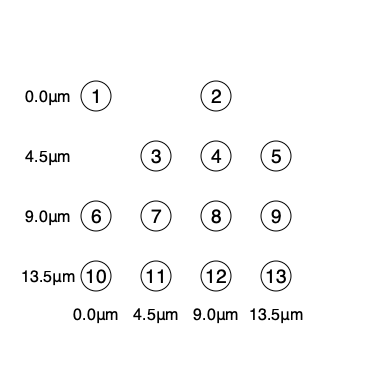

In [3]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

So very well, the above should represent the nodes of a graph. But how do we define edges? As mentioned, two atoms that are too close together are blocked from being both in the $| 1 \rangle$, or red, state. So we will abstract the atoms that are positioned closer than a "blockade radius" distance $R_b$, under which 2 qubits cannot be simultaneously $1$, to be connected by an edge.

Determining the $R_b$ scale is somewhat a tricky task. A good practice is to first determine an $R_{min}$, defining the minimal radius in which one would like to have atoms blocking each other, and an $R_{max}$, defining a radius after which one does not want atoms blocking each other. Then, a nice way to fix the desired blockade scale is to take the geometric mean $R_b=\sqrt{R_{min}R_{max}}$. 

Let's imagine we want the atoms to be connected to their first and second neighbors (when in a square lattice, this is known as a "king's graph", alluding to chess). In this case, $R_{min}=\sqrt{2}a$ -- blocking the first and second neighbors -- and $R_{max}=2a$ -- so not blocking third neighbors and beyond. 

Algother, we want $R_b=\sqrt{2\sqrt{2}}a\approx 7.57\mu m$.

In [25]:
Rb=sqrt(3*sqrt(5))*a

11.65509028850108

Let's plot and check

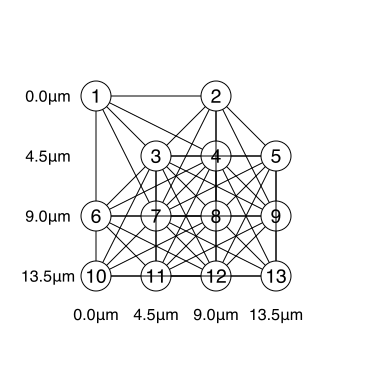

In [26]:
Bloqade.plot(atoms, blockade_radius = Rb)

Moving to the next step, We need to fix the algorithm. To solve the MIS in the graph above, we can pick an adiabatic approach. Adding a global heavy weight $\Delta$ to all sites should favor all qubits to be on state $| 1 \rangle$, while the Rydberg blockade should do, by itself and without need of our own control, the job of enforcing the constraint of no neighboring red nodes. The caveat is that the choice of parameters $\Delta$ and $\Omega$ is actually tied to the blockade radius. 

So we can imagine initializing the graph with all states painted white, $| 0 \rangle$, and evolving a very negative global $\Delta$ towards a positive value, with a finite $\Omega$ meanwhile to enable qubit flips from $0$ to $1$. Since the state we are looking for is classical, we may as well turn $\Omega$ off at the end of the protocol, which also facilitates fixing of the blockade radius: it will simply be defined by $\Delta$  as $R_b = (C_6/\Delta)^{1/6}$, where $C_6=2\pi \times 862690\, \text{MHz}\, \mu \text{m}^6$. The typical choice of $\Omega$ is to make it as large as possible; it helps on the quantum scrambling of states via bit flips and, in some sense, defines a clock speed of operations during the protocol. Ramping $\Delta$ slowly to its correct final value, then, defines an adiabatic protocol to solve the MIS problem.

Here is how we do that with Blockade, using piecewise linear time traces for the Hamiltonian parameters.

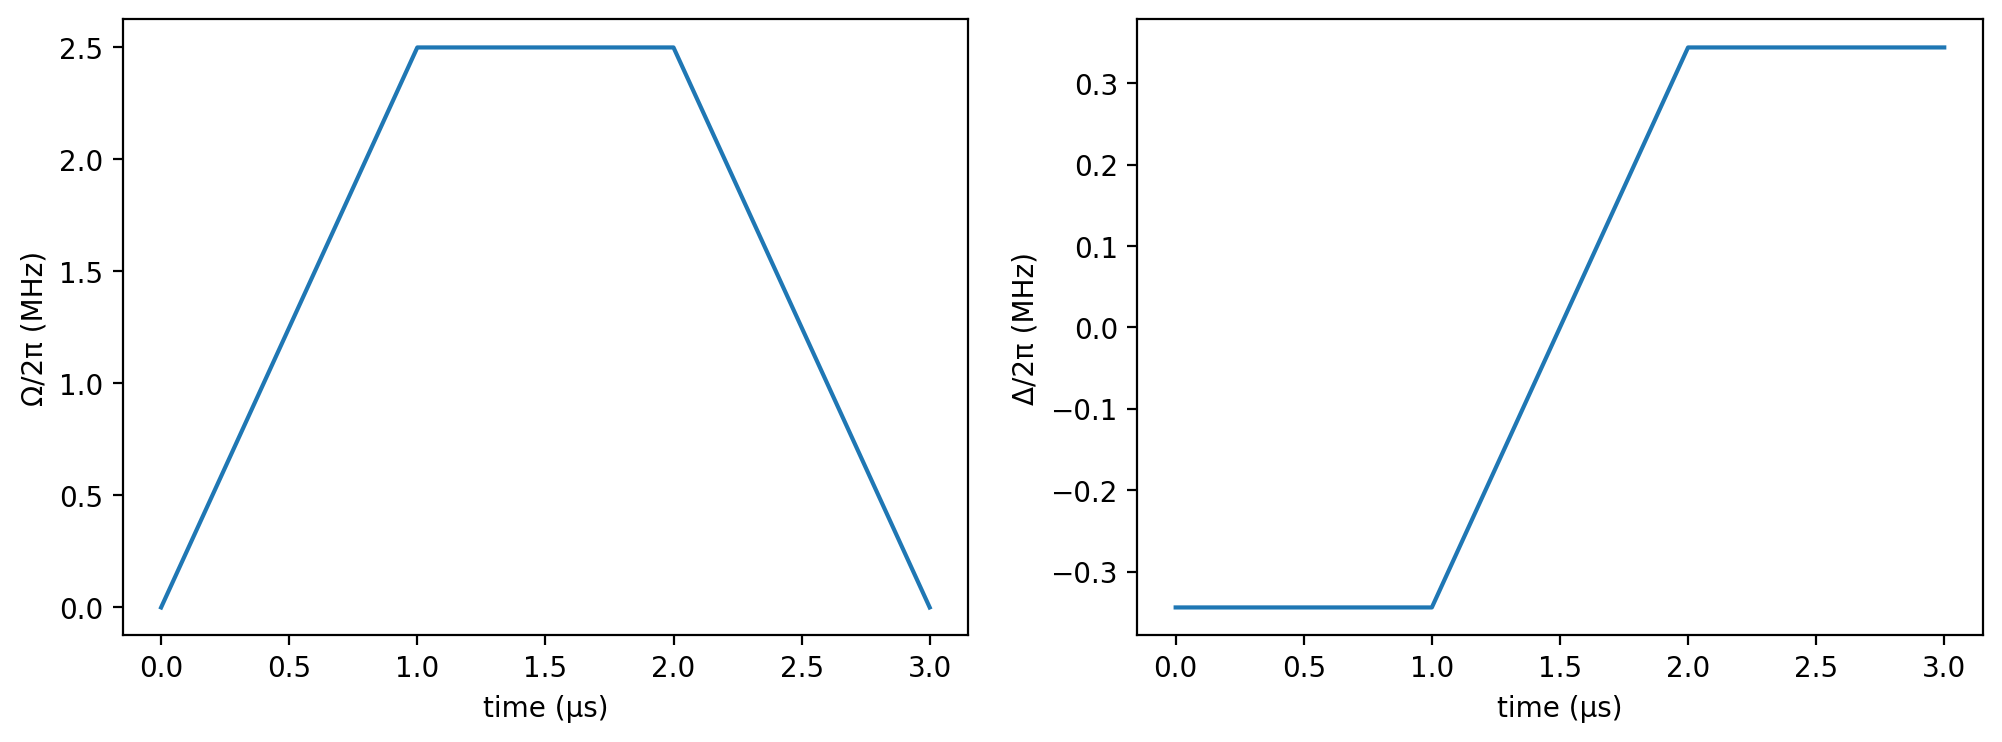

In [75]:
#Total evolution time
T_max = 3.0

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 1.0, 2.0, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 1.0, 2.0, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Optimizing these time traces can improve the convergence and likelihood of finding the MIS, but this will do for now. 

We initialize the problem with the parameters above, including a "zero_state" initial register for the Hamiltonian's qubits.

In [80]:
h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);

To emulate the time evolution, here goes the syntax

In [81]:
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 3.0)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


We are done. Now it is just a matter of enjoying the results by asking questions. For example, the 10 most probable basis states contributing to $| \psi(t=T_{Max}) \rangle$ are

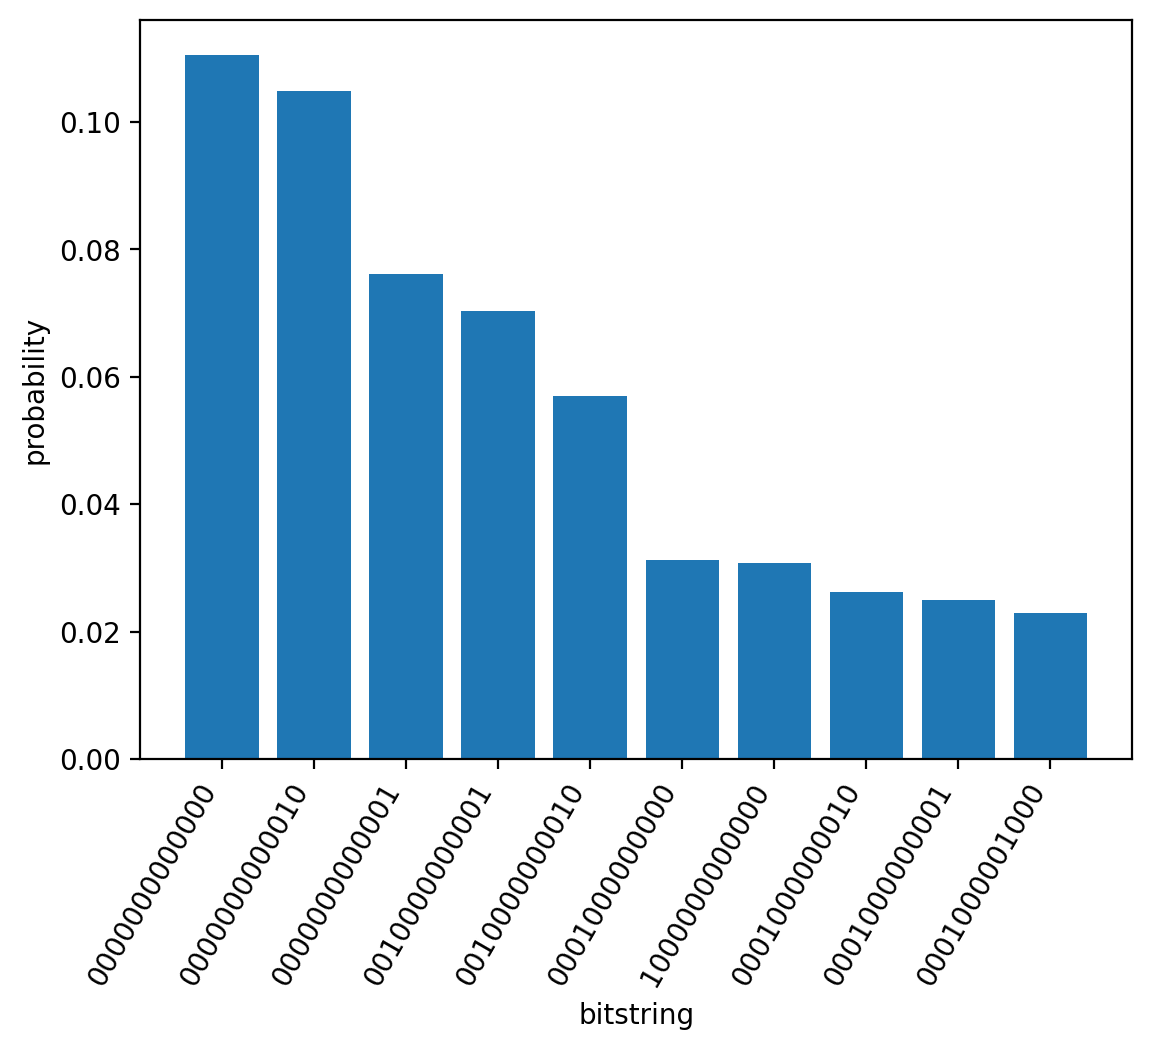

In [82]:
bitstring_hist(prob.reg; nlargest = 10)

We already see that a couple of them have larger probability than the others. Do they correspond to MIS? At this level, we can check by eye. Here are some plots of the solutions (i.e., a graph colored according to the labels of the states found above)

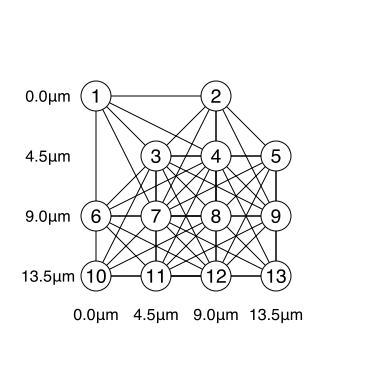

In [79]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

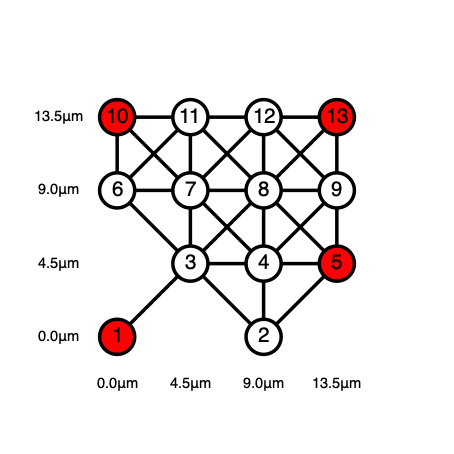

In [10]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

But note the 3rd most-likely bit string does **not** correspond to an MIS.

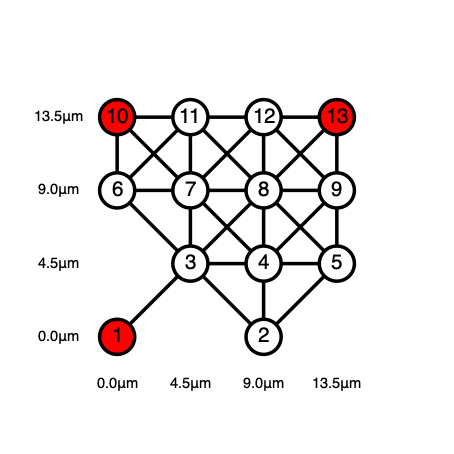

In [11]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])

This is an IS for sure, but not the maximum. Usually these solutions are called "|MIS|-1", and are actually quite important to study algorithmic performance. Other violations of the MIS would also be possible, including double connected excitations; these can also be improved into sub-optimal IS solutions via classical post-processing.

### Exercise:
Redo the process above to solve the MIS for the graph from our handout. Can you optimize the pulses for better performance?